# Time Series Visualization

dataset: https://www.kaggle.com/jswicker/the-smell-of-fear

some plots: https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/

In [122]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np

from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
sns.set(rc={'figure.figsize':(11, 4)})

## Parsing

I need to parse the dates so I can use them as index. 

Examples: 
```
tof_df.loc['2013-12-18 14:00:00':'2013-12-18 16:41:00']
tof_df.loc['2013-12']
```

In [10]:
tof_file = '../data/the-smell-of-fear/TOF_CO2_data_30sec.csv'
tof_df = pd.read_csv(tof_file)

tof_df['time_parsed'] = pd.to_datetime(tof_df.Time, dayfirst=False)
tof_df['only_date'] = pd.to_datetime(tof_df['time_parsed'].dt.date)
tof_df = tof_df.set_index('time_parsed')

In [11]:
screening_times = '../data/the-smell-of-fear/screening_times.csv'
screening_df = pd.read_csv(screening_times)

screening_df['parsed_begin'] = pd.to_datetime(screening_df['begin'],dayfirst=True)

# Fix bad laveling
print(screening_df['movie'].unique())
screening_df['movie'] = screening_df['movie'].str.replace('Bele & Sebastian', 'Belle & Sebastian')
screening_df['movie'] = screening_df['movie'].str.replace('The Little Ghost', 'Little Ghost')
screening_df['movie'] = screening_df['movie'].str.replace('Little Ghost', 'The Little Ghost')

['Hobbit 2' 'Carrie' 'Wolkig 2' 'Suck Me Shakespeer' 'Dinosaurier'
 'Walter Mitty' 'Counselor' 'Belle & Sebastian' 'Bolshoi: Dornröschen'
 'Machete Kills' 'Buddy' 'The Hunger Games: Catching Fire'
 'Journey to the Christmas Star' 'Medicus' 'The Little Ghost'
 'Little Ghost' 'The Starving Games' 'Paranormal Activity'
 'Bele & Sebastian']


In [12]:
def get_the_duration(movie):
    movies_duration = {'Hobbit 2': 161, 'Carrie': 98, 'Wolkig 2': 96, 'Suck Me Shakespeer': 119, 'Dinosaurier': 82,
                       'Walter Mitty': 125, 'Counselor': 120, 'Belle & Sebastian': 104, 'Bolshoi: Dornröschen': 165,
                       'Machete Kills': 108, 'Buddy': 86, 'The Hunger Games: Catching Fire': 146,
                       'Journey to the Christmas Star': 80, 'Medicus': 150, 'The Little Ghost': 92,
                       'The Starving Games': 83, 'Paranormal Activity': 86
                       }
    return movies_duration[movie]
screening_df['movie_duration'] = screening_df['movie'].apply(get_the_duration)
screening_df['parsed_end'] = screening_df['parsed_begin'] + pd.to_timedelta(screening_df['movie_duration'], unit='m')

Fill the measures dataset with the movie information for the analysis


In [13]:
tof_df['number visitors'] = 0
tof_df['movie'] = 0
tof_df['filled %'] = 0
tof_df['sample index'] = 0
for index, row in screening_df.iterrows():
    begin = str(row['parsed_begin'])
    end = str(row['parsed_end'])    
    if not tof_df.loc[begin:end].shape[0]:
        continue
    tof_df.loc[begin:end,'number visitors'] = row['number visitors']
    tof_df.loc[begin:end, 'movie'] = row['movie']
    tof_df.loc[begin:end, 'filled %'] = row['filled %']
    tof_df.loc[begin:end, 'sample index'] = index + 1 


In [14]:
tof_df.head()

,Time,CO2,m14.0028,m15.0238,m15.9962,m16.0201,m17.0260,m18.0338,m18.9921,m18.9995,...,m371.0984,m372.0993,m373.0832,m374.0818,m375.0743,only_date,number visitors,movie,filled %,sample index
time_parsed,,,,,,,,,,,,,,,,,,,,,
2013-12-18 11:46:00,'12/18/2013 11:46:00',610.208,1.92631,3.97879,1.76990,0.969783,355.235,3908.58,NaN,NaN,...,0.288172,0.211790,0.182142,0.126824,NaN,2013-12-18,0,0,0.0,0
2013-12-18 11:46:30,'12/18/2013 11:46:30',609.304,1.90129,4.74365,1.81630,0.905811,359.527,3922.42,NaN,NaN,...,0.388942,0.184603,0.249867,0.133148,NaN,2013-12-18,0,0,0.0,0
2013-12-18 11:47:00,'12/18/2013 11:47:00',608.475,1.97128,4.72838,1.97672,0.843545,361.429,3929.61,NaN,NaN,...,0.373633,0.223074,0.198287,0.150358,NaN,2013-12-18,0,0,0.0,0
2013-12-18 11:47:30,'12/18/2013 11:47:30',607.667,1.78681,4.53120,1.83743,0.841400,358.413,3910.84,NaN,NaN,...,0.370601,0.180225,0.232600,0.091334,NaN,2013-12-18,0,0,0.0,0
2013-12-18 11:48:00,'12/18/2013 11:48:00',606.660,2.07051,4.71770,1.87686,0.984419,358.288,3919.43,NaN,NaN,...,0.375249,0.193158,0.205937,0.154501,NaN,2013-12-18,0,0,0.0,0


In [15]:
screening_df.head()

,scheduled,movie,OV,HFR,3D,begin,number visitors,filled %,screening room,capacity,parsed_begin,movie_duration,parsed_end
0,12-12-2013 14:00,Hobbit 2,NaN,NaN,NaN,12-12-2013 14:00,26,10.92,2,238,2013-12-12 14:00:00,161,2013-12-12 16:41:00
1,12-12-2013 19:00,Hobbit 2,NaN,NaN,NaN,12-12-2013 19:00,88,36.97,2,238,2013-12-12 19:00:00,161,2013-12-12 21:41:00
2,12-12-2013 23:20,Carrie,NaN,NaN,NaN,12-12-2013 23:20,21,8.82,2,238,2013-12-12 23:20:00,98,2013-12-13 00:58:00
3,13-12-2013 14:00,Hobbit 2,NaN,NaN,NaN,13-12-2013 14:00,6,2.52,2,238,2013-12-13 14:00:00,161,2013-12-13 16:41:00
4,13-12-2013 19:00,Hobbit 2,NaN,NaN,NaN,13-12-2013 19:00,162,68.07,2,238,2013-12-13 19:00:00,161,2013-12-13 21:41:00


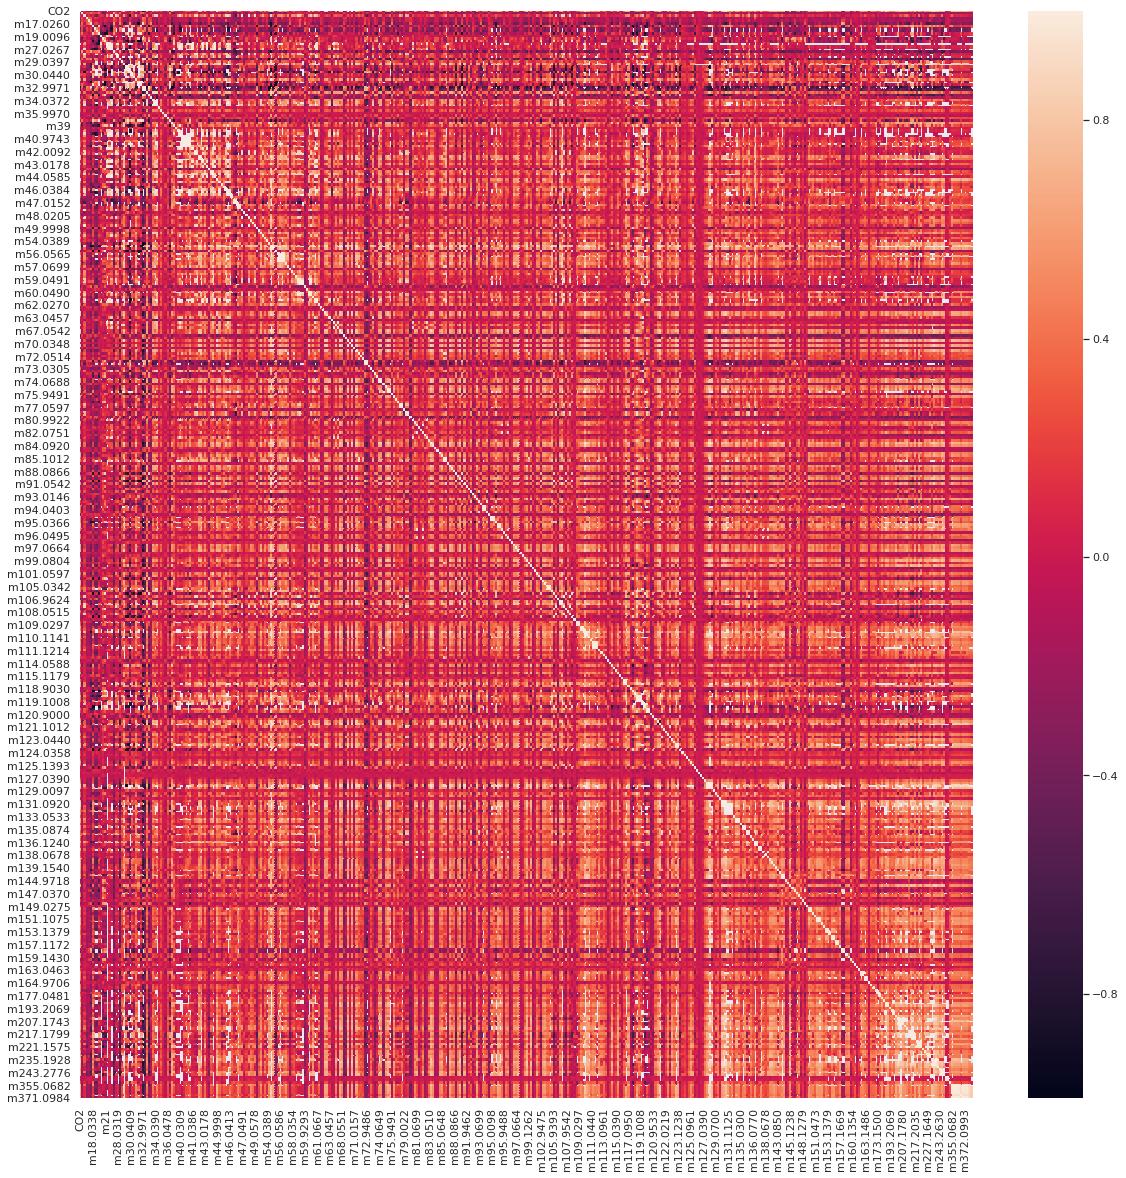

In [16]:
plt.figure(figsize=[20,20])
sns.heatmap(tof_df.iloc[:,1:431].corr())

In [71]:
def get_columns_with_too_much_nan(df,max_ratio=0.6):
    n_samples = df.shape[0]
    na_by_column = df.isna().sum()
    to_remove = []
    for column, n_nans in na_by_column.iteritems():
        nan_ratio = n_nans/n_samples
        if nan_ratio > max_ratio:
            to_remove.append(column)
    return to_remove
            


In [124]:
def get_pca_of_df(df):
    remove_columns = get_columns_with_too_much_nan(df)
    df_with_less_nans = df.drop(columns=remove_columns)
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    df_without_nans = df_with_less_nans.drop(columns=['Time', 'only_date', 'number visitors', 'movie', 'filled %', 'sample index'])
    values = imp_mean.fit_transform(df_with_less_nans.iloc[:,1:-5].values)
    df_without_nans.loc[:,:] = MinMaxScaler().fit_transform(values)
    pca = PCA()
    pca.fit(df_without_nans)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    pca = PCA(n_components=100)
    transformed = pca.fit_transform(tof_df_without_nans)  
    transformed_df = pd.DataFrame(transformed, index=df.index, columns= ['pc_{}'.format(i) for i in range(transformed.shape[1])])
    return transformed_df

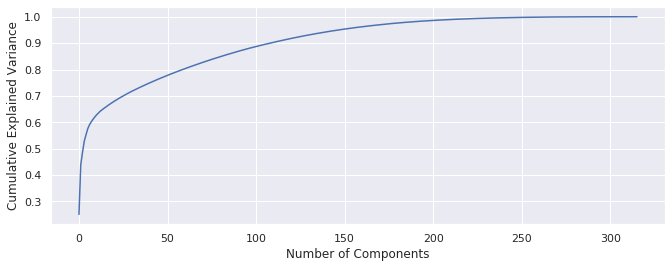

In [125]:
transformed_df = get_pca_of_df(tof_df)

## Analysis of the air

In [166]:
def plot_by_day(df,begin_date, end_date, target_columns,title):
    axes = df.loc[begin_date:end_date, target_columns].plot(marker='.', alpha=0.5, linestyle='None', figsize=(20, 3*len(target_columns)), subplots=True)
    for i,ax in enumerate(axes):
        if i == 0:
            ax.set_title(title)
        ax.set_ylabel(target_columns[i])
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    
def plot_by_hour(df,begin_date, end_date, target_columns,title,interval=1):
    axes = df.loc[begin_date:end_date, target_columns].plot(marker='.', alpha=0.5, linestyle='None',figsize=(20, 3*len(target_columns)),subplots=True)
    for i, ax in enumerate(axes):
        if i == 0:
            ax.set_title(title)
        ax.set_ylabel(target_columns[i])
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=interval))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:00'))
    plt.show()

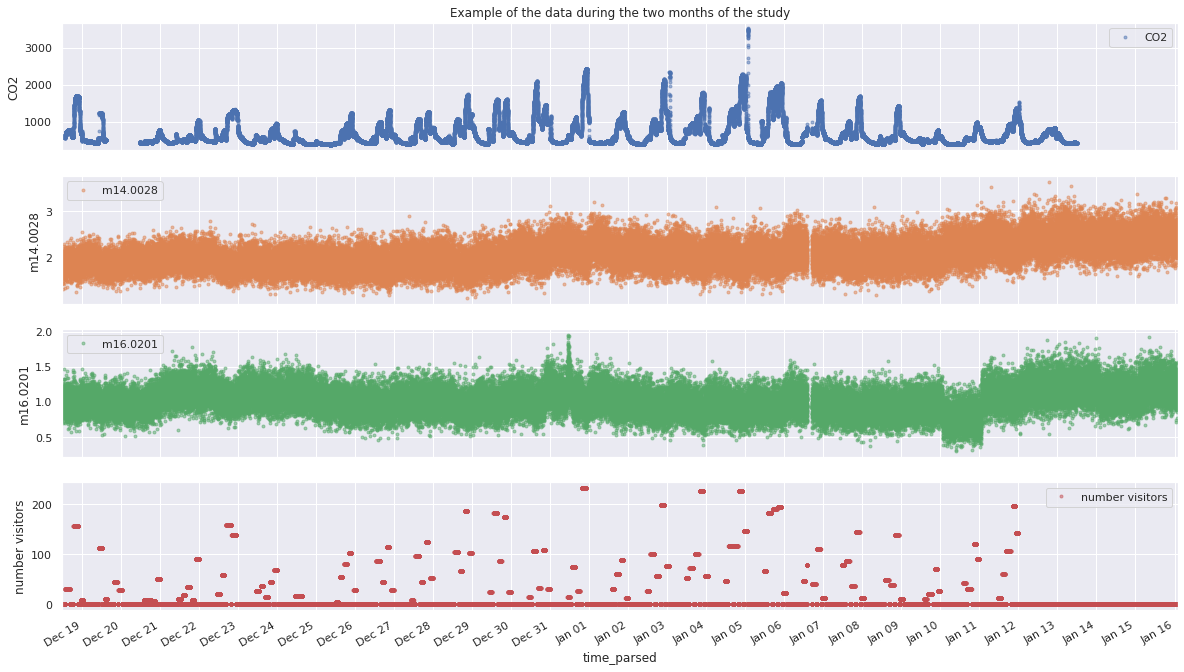

In [167]:
cols_plot = ['CO2', 'm14.0028', 'm16.0201','number visitors']
plot_by_day(tof_df, '2013-12-18','2014-01-16',cols_plot, 'Example of the data during the two months of the study')

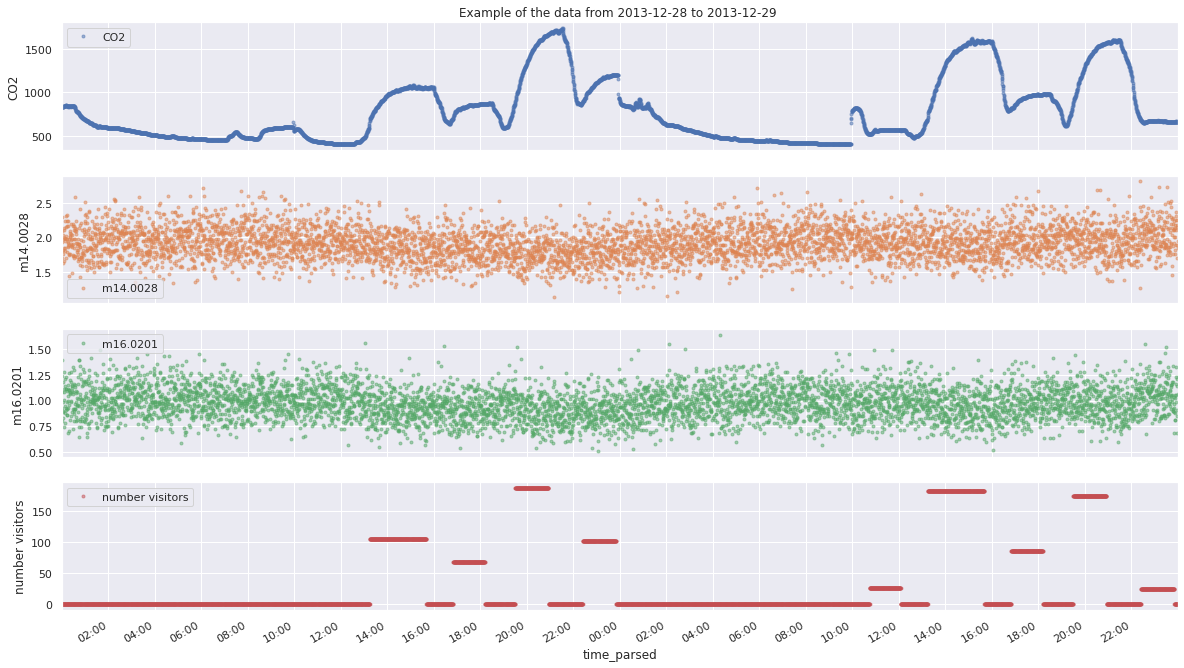

In [162]:
cols_plot = ['CO2', 'm14.0028', 'm16.0201','number visitors']
plot_by_hour(tof_df, '2013-12-28','2013-12-29',cols_plot,'Example of the data from 2013-12-28 to 2013-12-29 ', interval=2)

Index(['Time', 'CO2', 'm14.0028', 'm15.0238', 'm15.9962', 'm16.0201',
       'm17.0260', 'm18.0338', 'm18.9921', 'm18.9995', 'm19.0088', 'm19.0096',
       'm20.0236', 'm21', 'm27.0229'],
      dtype='object')

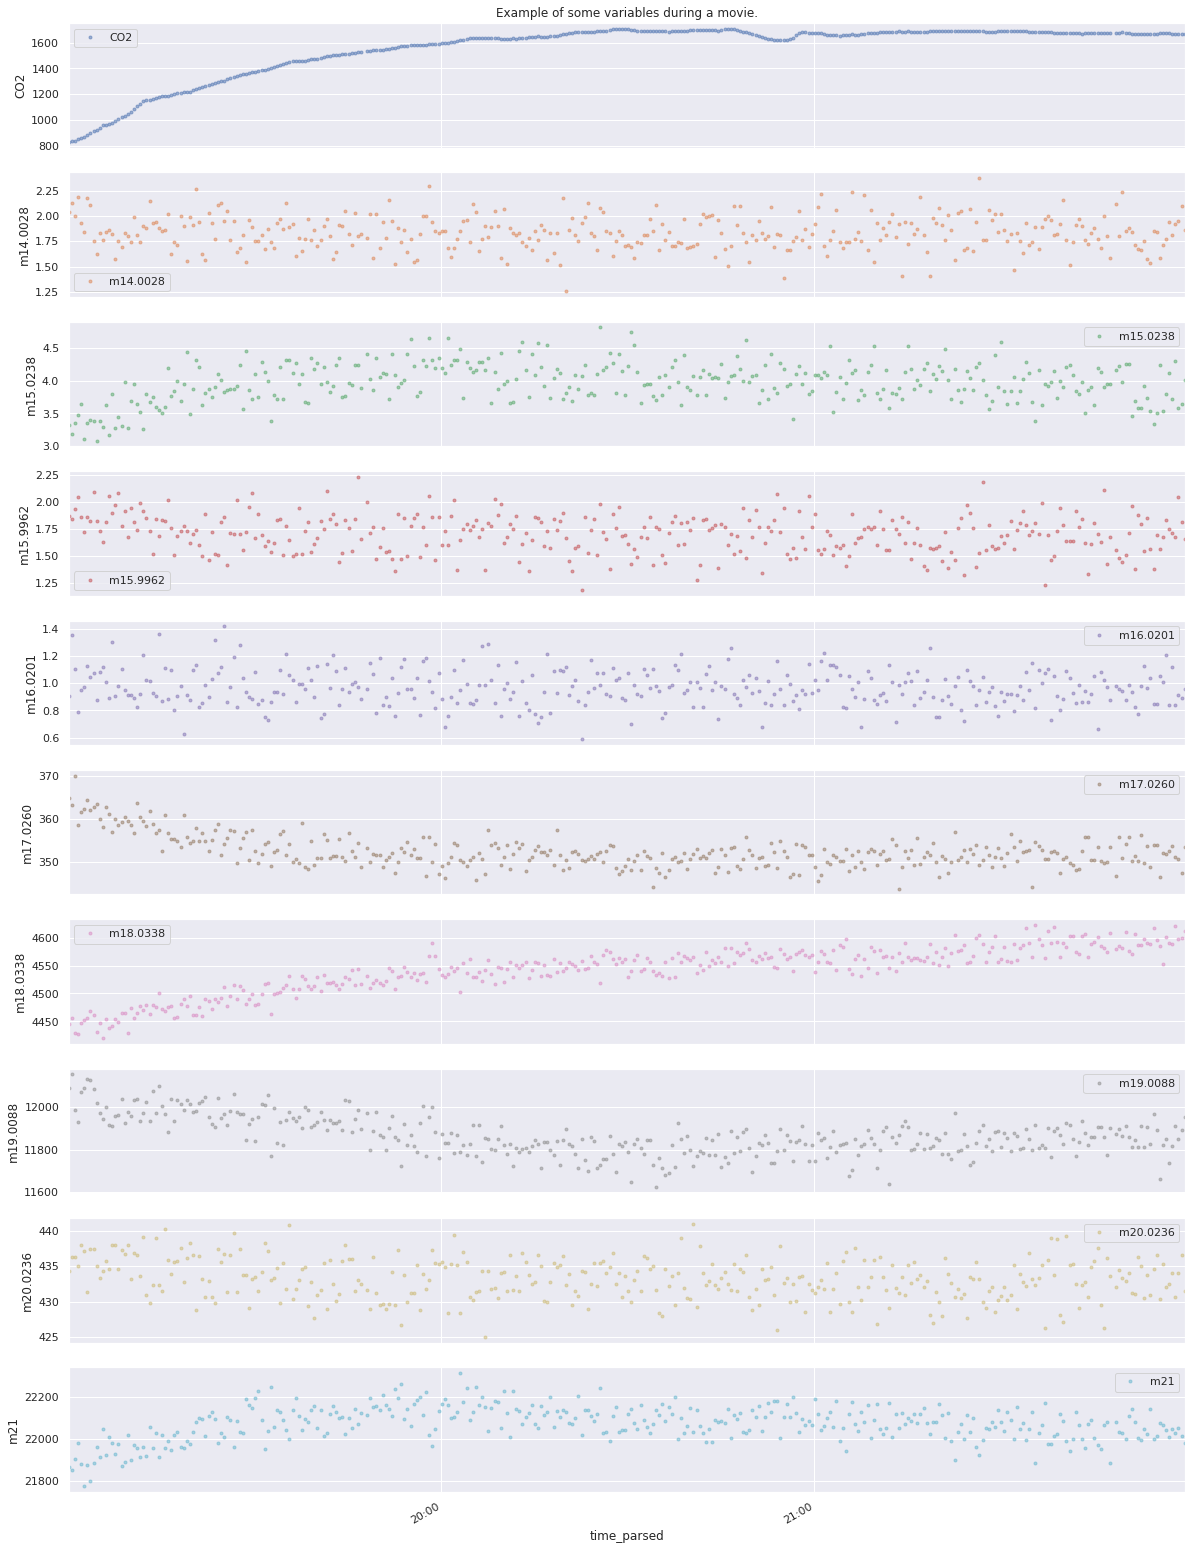

In [170]:
target_columns = ['CO2','m14.0028','number visitors']
plot_by_hour(tof_df,'2013-12-18 19:00:00', '2013-12-18 22:00:00',['CO2', 'm14.0028', 'm15.0238', 'm15.9962', 'm16.0201',
       'm17.0260', 'm18.0338',  'm19.0088', 'm20.0236', 'm21'], title='Example of some variables during a movie.')


## Analysis of the movies

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text xticklabel objects>)

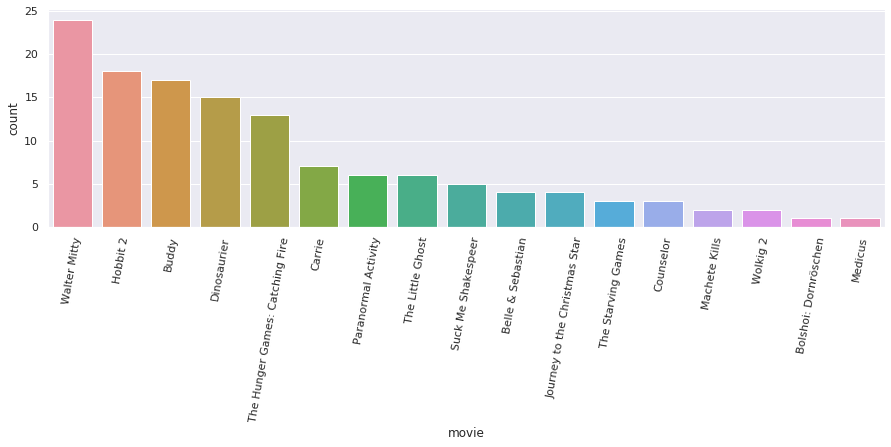

In [20]:
plt.figure(figsize=[15,4])
sns.countplot(data=screening_df, x='movie',order = screening_df['movie'].value_counts().index)
plt.xticks(rotation=80)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text xticklabel objects>)

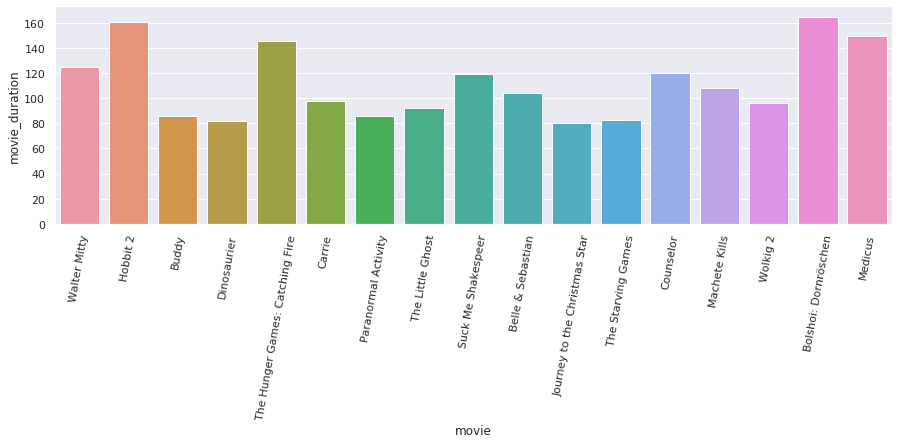

In [21]:
plt.figure(figsize=[15,4])
sns.barplot(data=screening_df, x='movie', y='movie_duration', order = screening_df['movie'].value_counts().index )
plt.xticks(rotation=80)

# Work in progress

In [22]:
def get_the_colors(movie):
    colors = ['#000000','#003f5c', '#2f4b7c', '#665191', '#a05195', '#d45087', '#f95d6a', '#ff7c43', '#ffa600', '#003f5c',
              '#2f4b7c', '#665191', '#a05195', '#d45087', '#f95d6a', '#ff7c43', '#ffa600','#008F7A']
    movies = [0,'Hobbit 2', 'Carrie', 'Wolkig 2', 'Suck Me Shakespeer', 'Dinosaurier', 'Walter Mitty', 'Counselor', 'Belle & Sebastian', 'Bolshoi: Dornröschen', 'Machete Kills', 'Buddy', 'The Hunger Games: Catching Fire', 'Journey to the Christmas Star', 'Medicus', 'The Little Ghost', 'The Starving Games', 'Paranormal Activity']
    movie_colors = dict(zip(movies,colors))
    return movie_colors[movie]

<Figure size 1440x288 with 0 Axes>

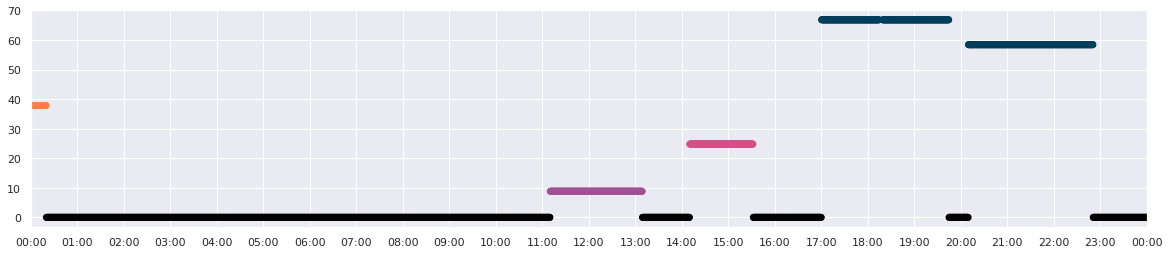

In [23]:
plt.figure(figsize=[20,4])

df_section = tof_df.loc['2013-12-22':'2013-12-23'].reset_index()

fig, ax = plt.subplots(figsize=[20,4])
ax.scatter(x= df_section['time_parsed'],y=df_section['filled %'],color=tof_df.loc['2013-12-22':'2013-12-23','movie'].apply(get_the_colors))
plt.xlim('2013-12-22','2013-12-23')
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:00'))

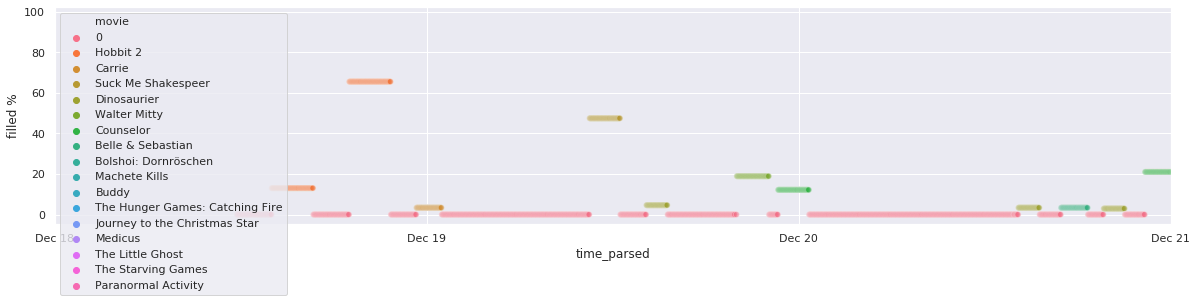

In [24]:
plt.figure(figsize=[20,4])

df_section = tof_df.loc['2013-12-22':'2013-12-23'].reset_index()

# fig, ax = plt.subplots()
ax = sns.scatterplot(data=tof_df.reset_index(),x='time_parsed',y='filled %', hue='movie',alpha=0.1)
plt.xlim('2013-12-18','2013-12-21')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

In [25]:
tof_df.movie.unique()

array([0, 'Hobbit 2', 'Carrie', 'Suck Me Shakespeer', 'Dinosaurier',
       'Walter Mitty', 'Counselor', 'Belle & Sebastian',
       'Bolshoi: Dornröschen', 'Machete Kills', 'Buddy',
       'The Hunger Games: Catching Fire', 'Journey to the Christmas Star',
       'Medicus', 'The Little Ghost', 'The Starving Games',
       'Paranormal Activity'], dtype=object)

# Transform the dataset into a supervised problem

I will select the sections of the data corresponding to the most common movies: Hobbit 2, Walter Mitty, Buddy, Hunger games and Dinosaurier. 

The samples of the new dataset will have 2 dimensions: 
* The time steps 
* The features

In [253]:
target_movies = ['Hobbit 2', 'Buddy', 'Walter Mitty', 'The Hunger Games: Catching Fire','Dinosaurier']

df_movies = tof_df.loc[tof_df['movie'].isin(target_movies),:]
transformed_movies = transformed_df.loc[tof_df['movie'].isin(target_movies),:]
df_movies

,Time,CO2,m14.0028,m15.0238,m15.9962,m16.0201,m17.0260,m18.0338,m18.9921,m18.9995,...,m371.0984,m372.0993,m373.0832,m374.0818,m375.0743,only_date,number visitors,movie,filled %,sample index
time_parsed,,,,,,,,,,,,,,,,,,,,,
2013-12-18 14:00:02,'12/18/2013 14:00:02',619.494,1.85029,3.17057,1.72606,1.039010,364.949,4254.93,NaN,NaN,...,0.415951,0.211048,0.228517,0.165493,NaN,2013-12-18,31,Hobbit 2,13.03,21
2013-12-18 14:00:32,'12/18/2013 14:00:32',620.278,1.61288,3.85020,1.72290,0.823970,361.499,4269.66,NaN,NaN,...,0.510154,0.270600,0.248050,0.166774,NaN,2013-12-18,31,Hobbit 2,13.03,21
2013-12-18 14:01:02,'12/18/2013 14:01:02',621.359,2.02692,3.96246,1.78672,1.210510,365.634,4271.77,NaN,NaN,...,0.465339,0.224658,0.297114,0.149893,NaN,2013-12-18,31,Hobbit 2,13.03,21
2013-12-18 14:01:32,'12/18/2013 14:01:32',622.780,2.08938,3.61794,2.03494,1.320790,369.164,4284.40,NaN,NaN,...,0.481612,0.231731,0.270819,0.109096,NaN,2013-12-18,31,Hobbit 2,13.03,21
2013-12-18 14:02:02,'12/18/2013 14:02:02',625.323,1.58202,3.69990,1.81779,1.101670,368.757,4277.96,NaN,NaN,...,0.538601,0.221212,0.268511,0.149329,NaN,2013-12-18,31,Hobbit 2,13.03,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-01-11 19:08:50,'01/11/2014 19:08:50',948.644,1.97780,2.58966,1.47155,1.152940,440.670,6128.27,1145.60,3210.19,...,0.521941,0.277859,0.324756,NaN,NaN,2014-01-11,107,Hobbit 2,47.13,129
2014-01-11 19:09:20,'01/11/2014 19:09:20',949.461,1.96742,2.83032,1.65951,0.835090,440.500,6123.63,1032.97,3268.68,...,0.418396,0.244416,0.211642,NaN,NaN,2014-01-11,107,Hobbit 2,47.13,129
2014-01-11 19:09:50,'01/11/2014 19:09:50',947.428,2.51630,2.62132,1.68251,1.183880,444.414,6111.18,1002.82,3238.48,...,0.488251,0.208942,0.275177,NaN,NaN,2014-01-11,107,Hobbit 2,47.13,129


In [246]:
df_movies.shape[0]*0.

(16539, 436)

In [249]:
has_nans = df_movies.isna().sum().reset_index()
has_nans.columns = ['feature', 'sum']
only_nans = has_nans[has_nans['sum']>8269.5]
only_nans['%'] = only_nans['sum'] / df_movies.shape[0]*100

/home/raquel/Documents/mai/deep_learning_deliveries/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [250]:
only_nans.shape

(124, 3)

Text(0.5, 1.0, 'Percentage of missing values by variable')

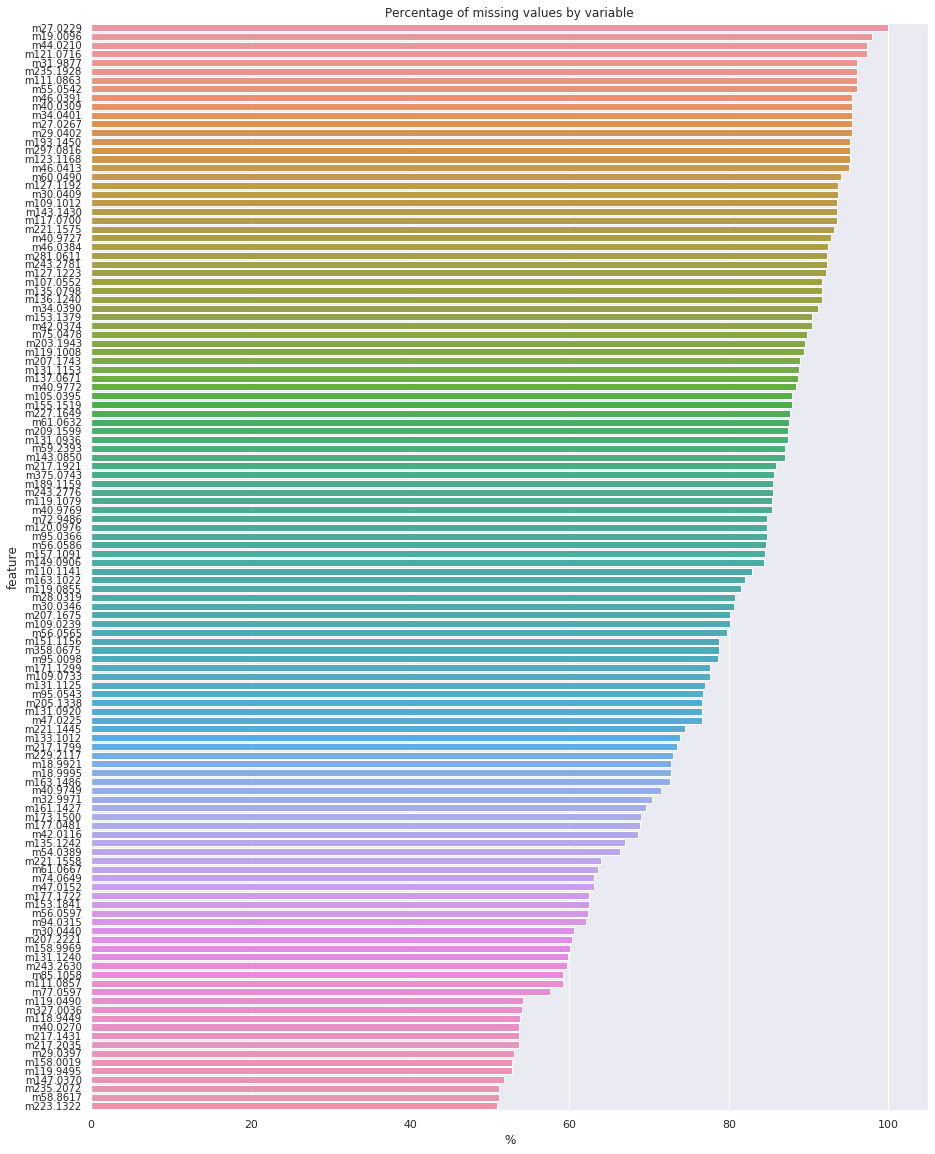

In [252]:
plt.figure(figsize=[15,20])
sns.barplot(data=only_nans,x='%',y='feature', orient='h',order=only_nans.sort_values(['sum'],ascending=False)['feature'])
plt.yticks(fontsize=10)
plt.title('Percentage of missing values by variable')

In [255]:
def get_columns_with_too_much_nan(df,max_ratio=0.6):
    n_samples = df.shape[0]
    na_by_column = df.isna().sum()
    to_remove = []
    for column, n_nans in na_by_column.iteritems():
        nan_ratio = n_nans/n_samples
        if nan_ratio > max_ratio:
            to_remove.append(column)
    return to_remove
            
remove_columns = get_columns_with_too_much_nan(df_movies)
df_movies = df_movies.drop(columns=remove_columns)

In [257]:
df_movies.shape

(16539, 330)

In [256]:
print('Nan ratio: ',df_movies.isna().sum().sum() / (df_movies.shape[0] * df_movies.shape[1]))

Nan ratio:  0.07737853778122235


In [29]:
sample_indexes = df_movies['sample index'].unique()
print('We will have a total number of {} samples'.format(len(sample_indexes)))

We will have a total number of 74 samples


In [30]:
print(df_movies.columns[1:325])

Index(['CO2', 'm14.0028', 'm15.0238', 'm15.9962', 'm16.0201', 'm17.0260',
       'm18.0338', 'm19.0088', 'm20.0236', 'm21',
       ...
       'm243.2630', 'm327.0036', 'm355.0682', 'm355.0726', 'm356.0714',
       'm357.0682', 'm371.0984', 'm372.0993', 'm373.0832', 'm374.0818'],
      dtype='object', length=324)


In [31]:
from sklearn.preprocessing import MinMaxScaler


def min_max_scaler(x):
    for i in range(x.shape[1]):
        x[:, i, :] = MinMaxScaler().fit_transform(x[:, i, :])
    return x

In [133]:
transformed_df.shape , df_movies.shape

((81606, 100), (16539, 330))

In [135]:
movie_labels = []
movie_data = []
transformed_movie_data = []
for index in sample_indexes:
    movie_label = df_movies.loc[df_movies['sample index']==index, 'movie'].unique()[0]
    print('Sample {}\nLabel: {}'.format(index, movie_label))
    
    data_sample = df_movies.loc[df_movies['sample index']==index,df_movies.columns[1:325]]
    pca_sample = transformed_movies.loc[df_movies['sample index']==index,:]
    #data_sample = min_max_scaler(data_sample.values)
    data_sample = data_sample.fillna(-1, inplace=False)
    print('Data shape: {}\n'.format( data_sample.shape))
    
    movie_labels.append(movie_label)
    movie_data.append(data_sample)
    transformed_movie_data.append(pca_sample)

Sample 21
Label: Hobbit 2
Data shape: (321, 324)

Sample 22
Label: Hobbit 2
Data shape: (321, 324)

Sample 25
Label: Dinosaurier
Data shape: (164, 324)

Sample 26
Label: Walter Mitty
Data shape: (249, 324)

Sample 28
Label: Dinosaurier
Data shape: (164, 324)

Sample 30
Label: Dinosaurier
Data shape: (163, 324)

Sample 33
Label: Dinosaurier
Data shape: (164, 324)

Sample 35
Label: Dinosaurier
Data shape: (163, 324)

Sample 38
Label: Dinosaurier
Data shape: (163, 324)

Sample 40
Label: Hobbit 2
Data shape: (320, 324)

Sample 42
Label: Dinosaurier
Data shape: (163, 324)

Sample 47
Label: Dinosaurier
Data shape: (163, 324)

Sample 48
Label: Buddy
Data shape: (171, 324)

Sample 49
Label: Buddy
Data shape: (172, 324)

Sample 50
Label: Buddy
Data shape: (171, 324)

Sample 51
Label: Buddy
Data shape: (171, 324)

Sample 52
Label: Buddy
Data shape: (172, 324)

Sample 53
Label: The Hunger Games: Catching Fire
Data shape: (291, 324)

Sample 54
Label: Dinosaurier
Data shape: (164, 324)

Sample 55
L

In [49]:
indices = np.arange(len(padded_dataset))

x_train, x_test, y_train, y_test,  idx1, idx2= train_test_split(padded_dataset, movie_labels,indices, test_size=0.2, random_state=42)
idx2

array([ 4, 63, 18,  0, 28, 73, 10, 34, 12, 55, 65, 31,  9, 45,  5])

In [54]:
real_test_indexes = [sample_indexes[i] for i in idx2]

Dinosaurier 8


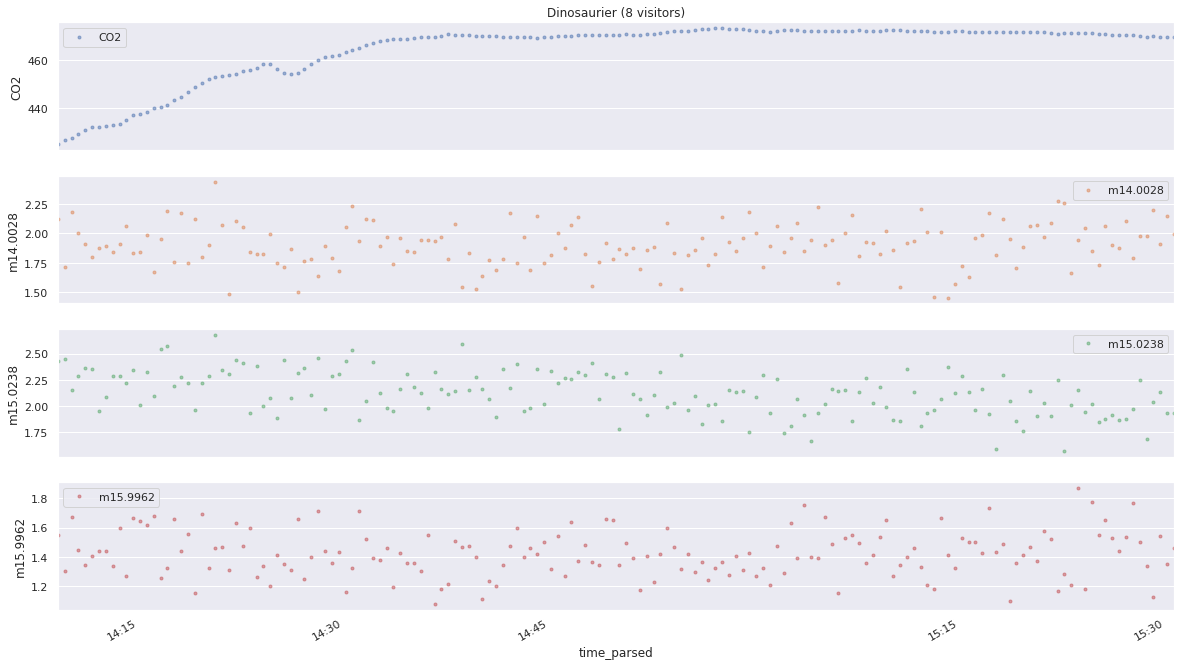

The Hunger Games: Catching Fire 87


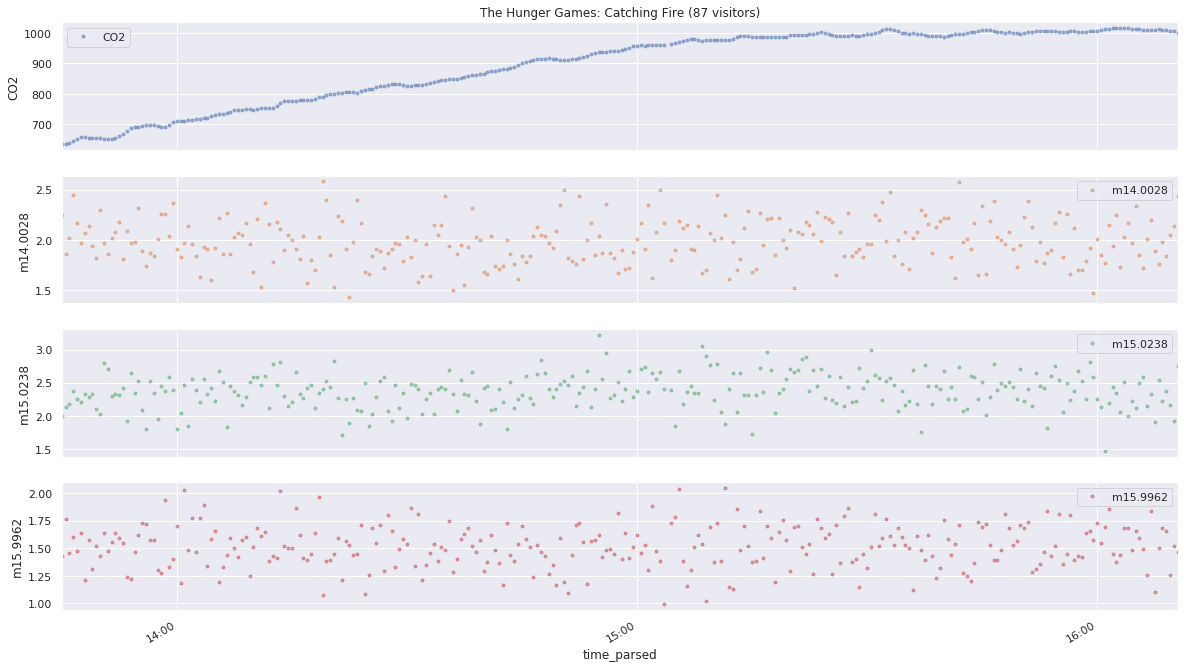

Dinosaurier 44


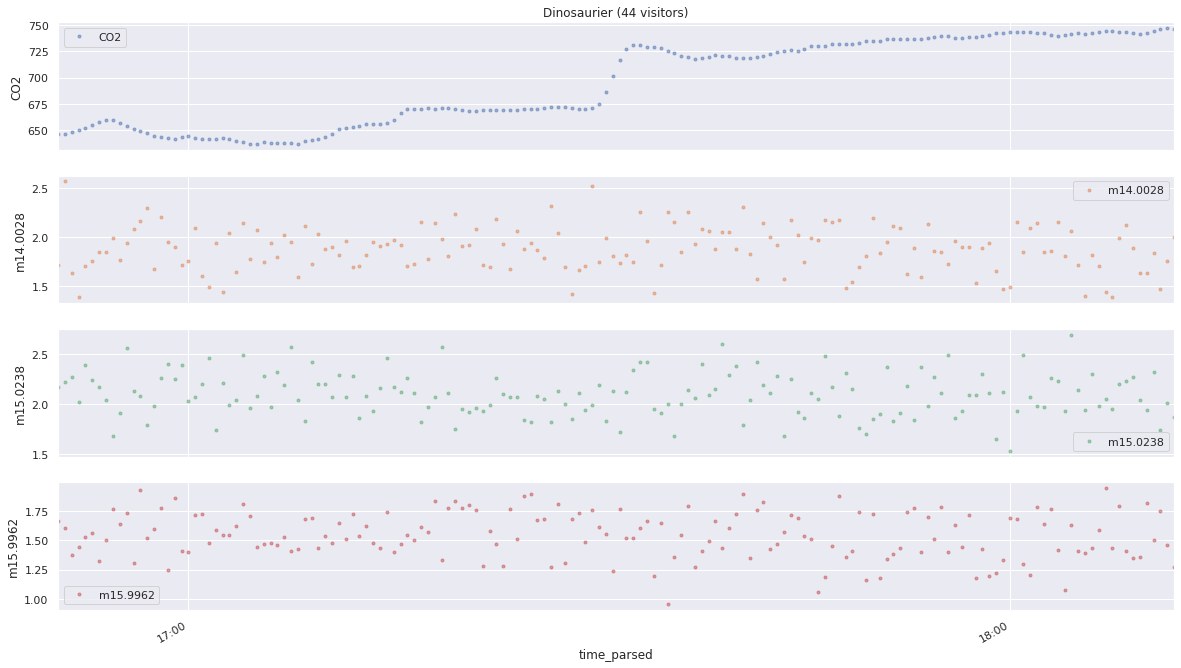

Hobbit 2 31


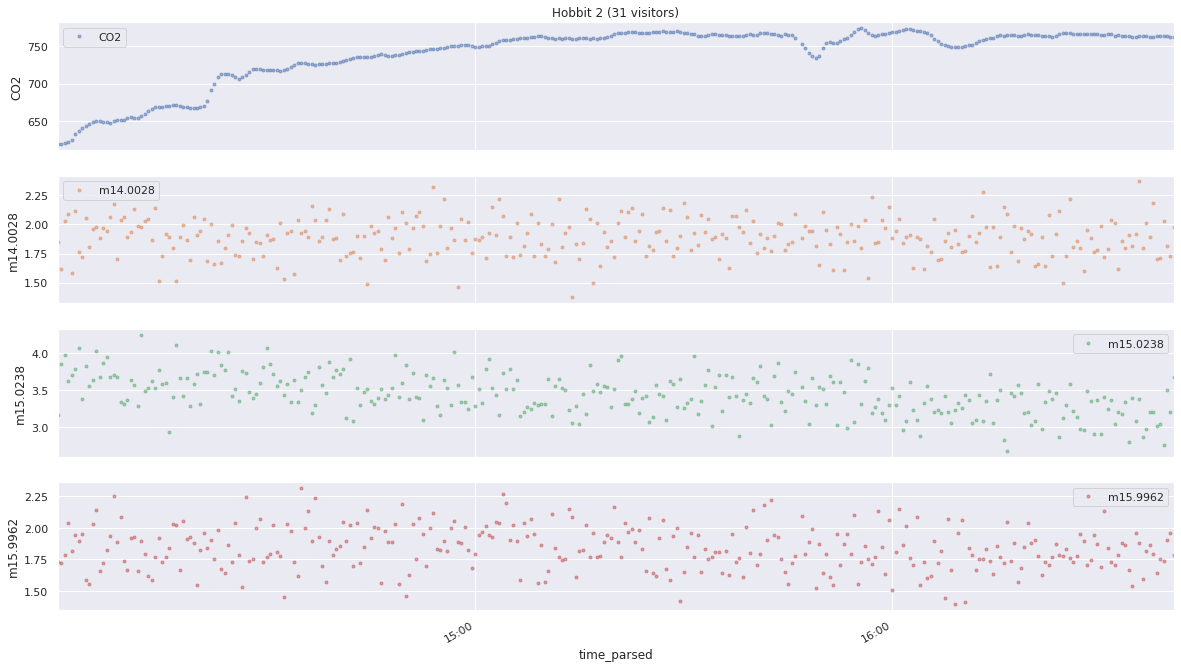

Buddy 102


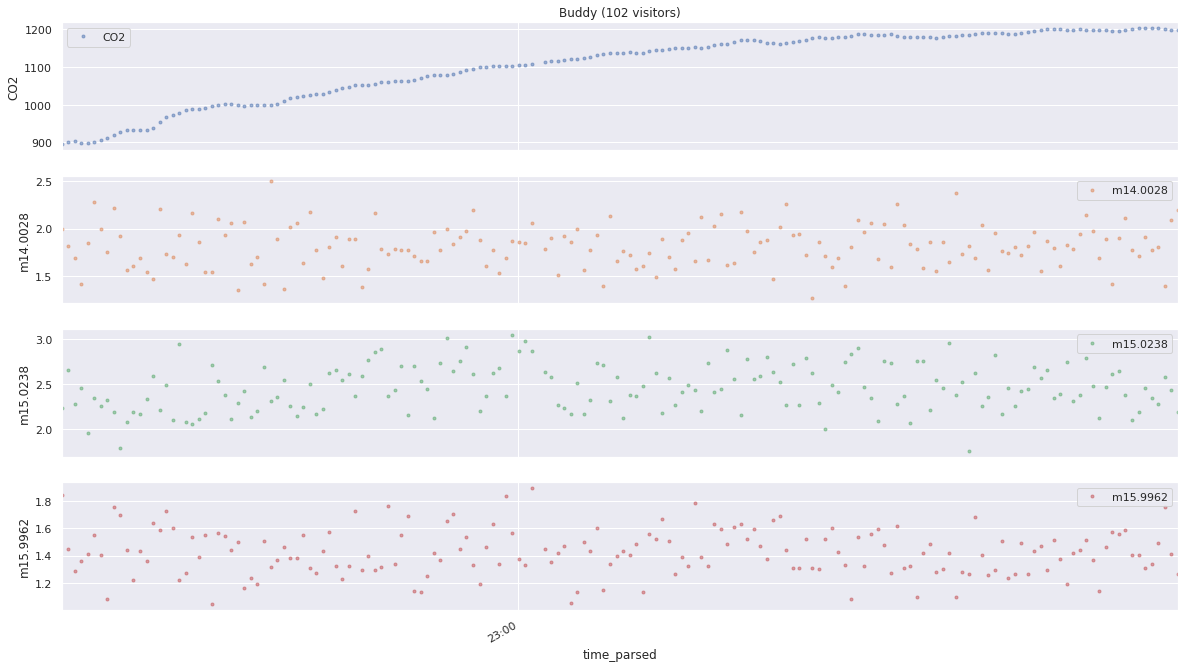

Hobbit 2 107


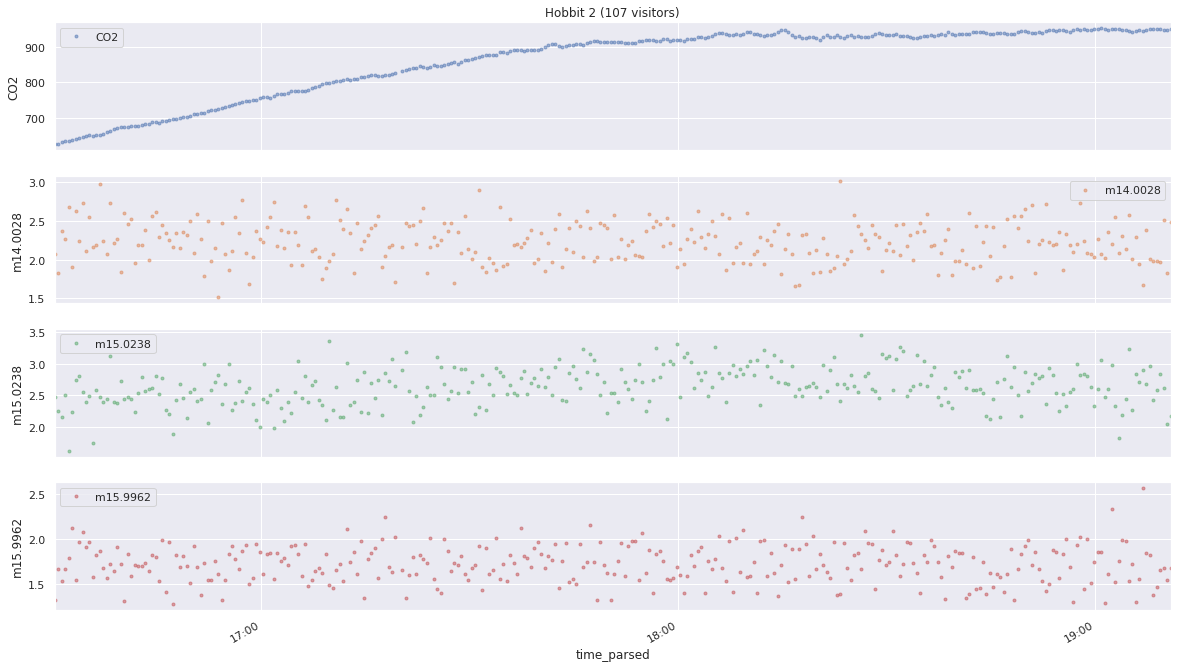

Dinosaurier 36


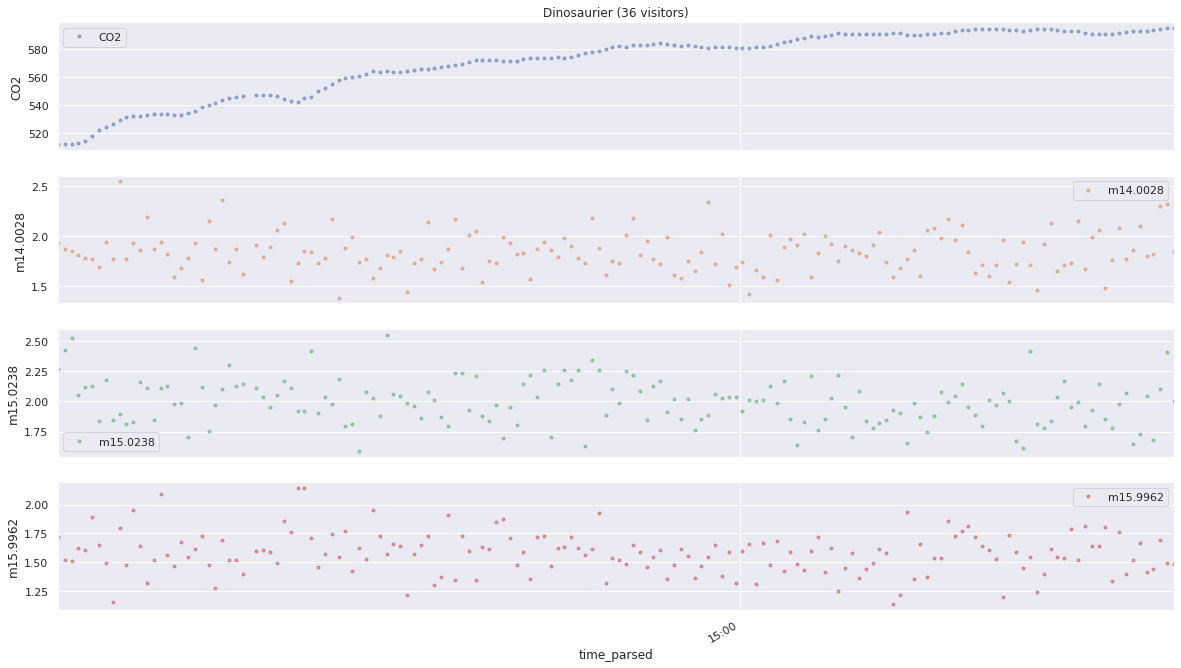

Dinosaurier 33


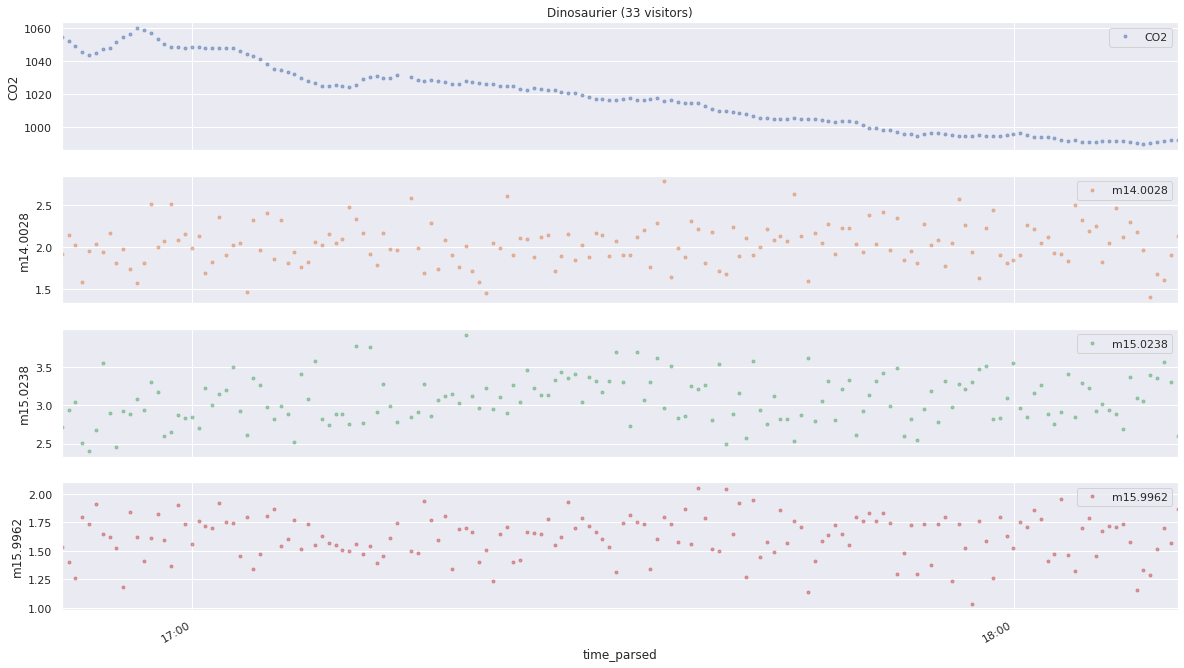

Buddy 5


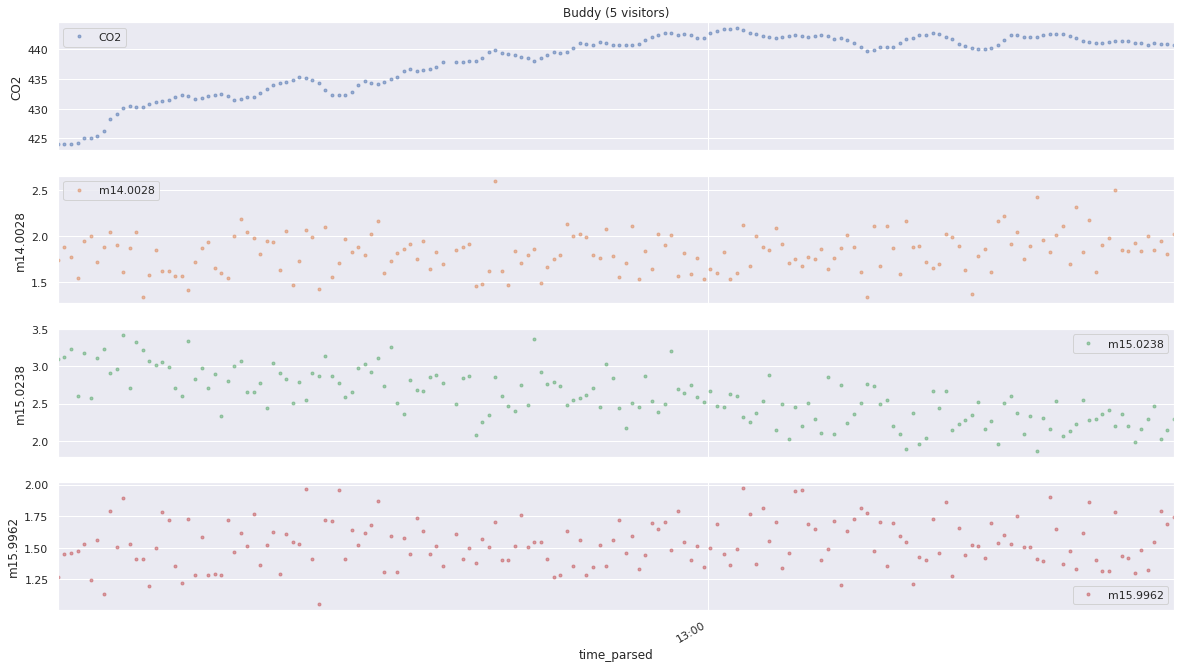

The Hunger Games: Catching Fire 183


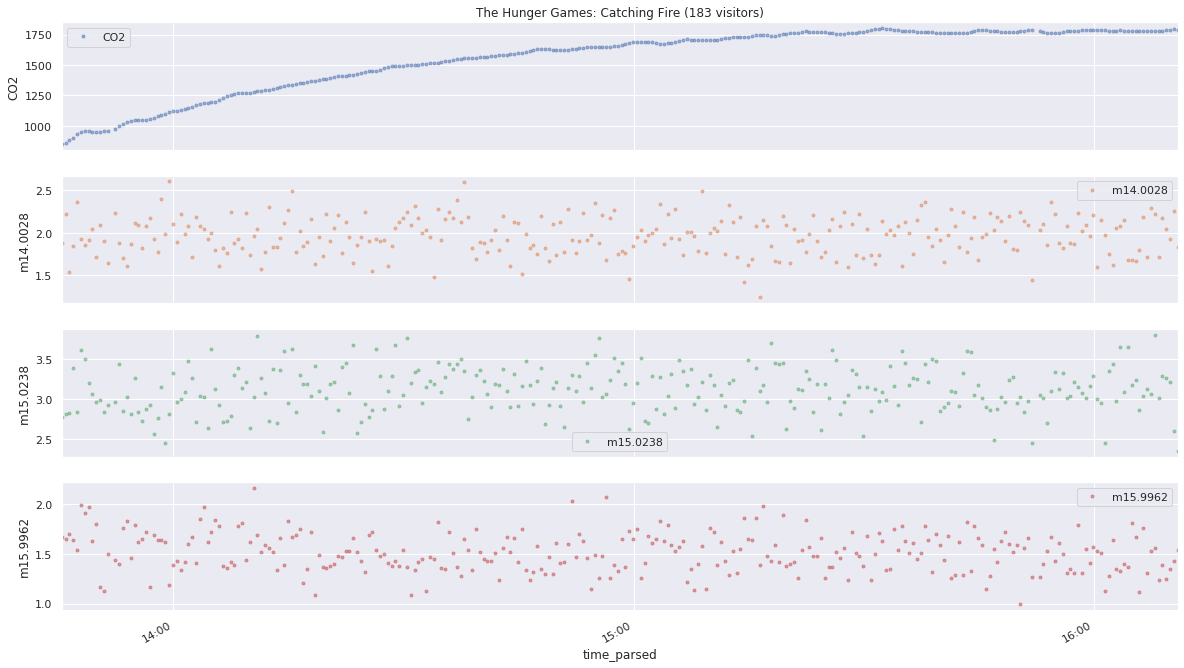

Walter Mitty 145


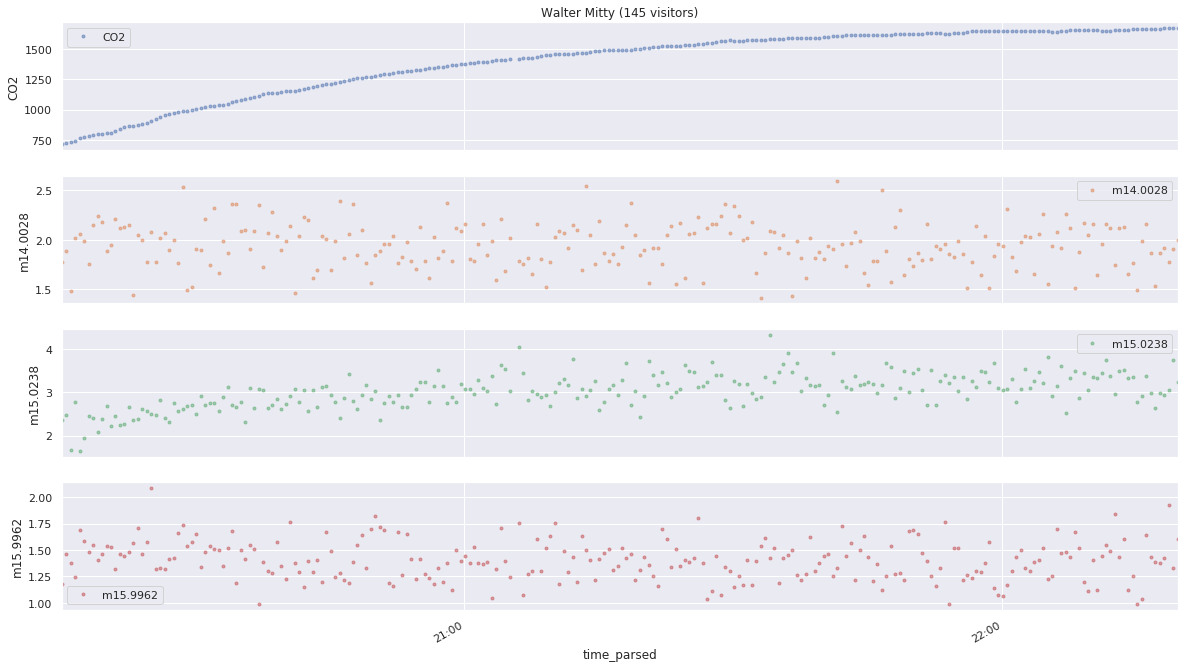

Buddy 174


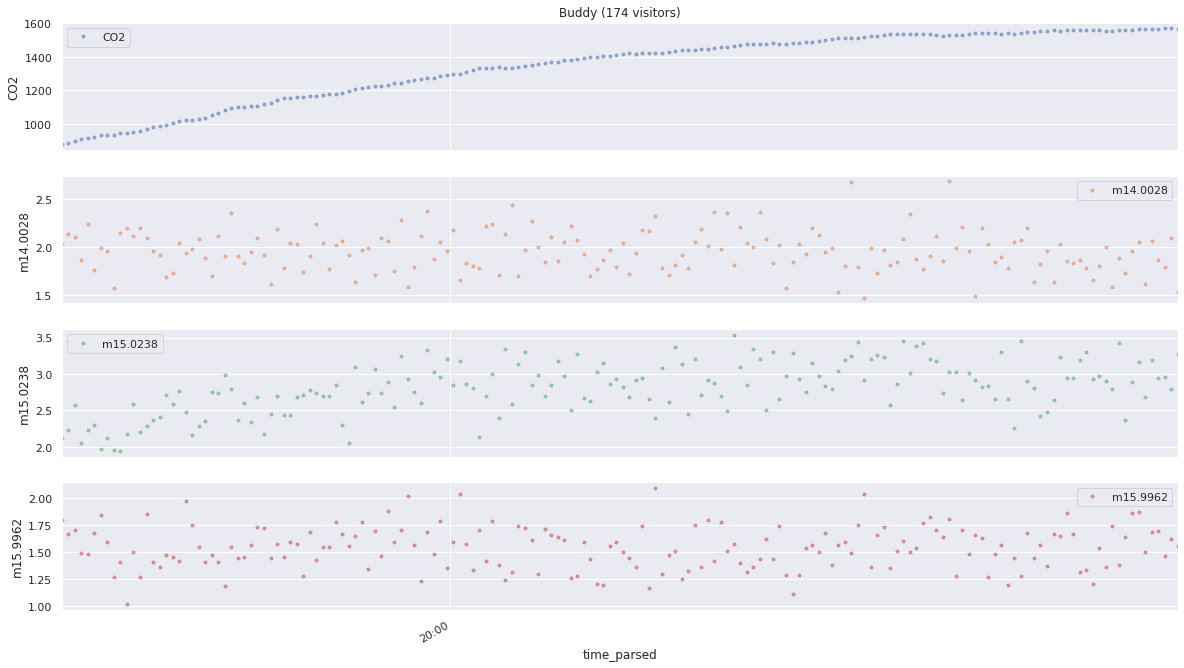

Hobbit 2 139


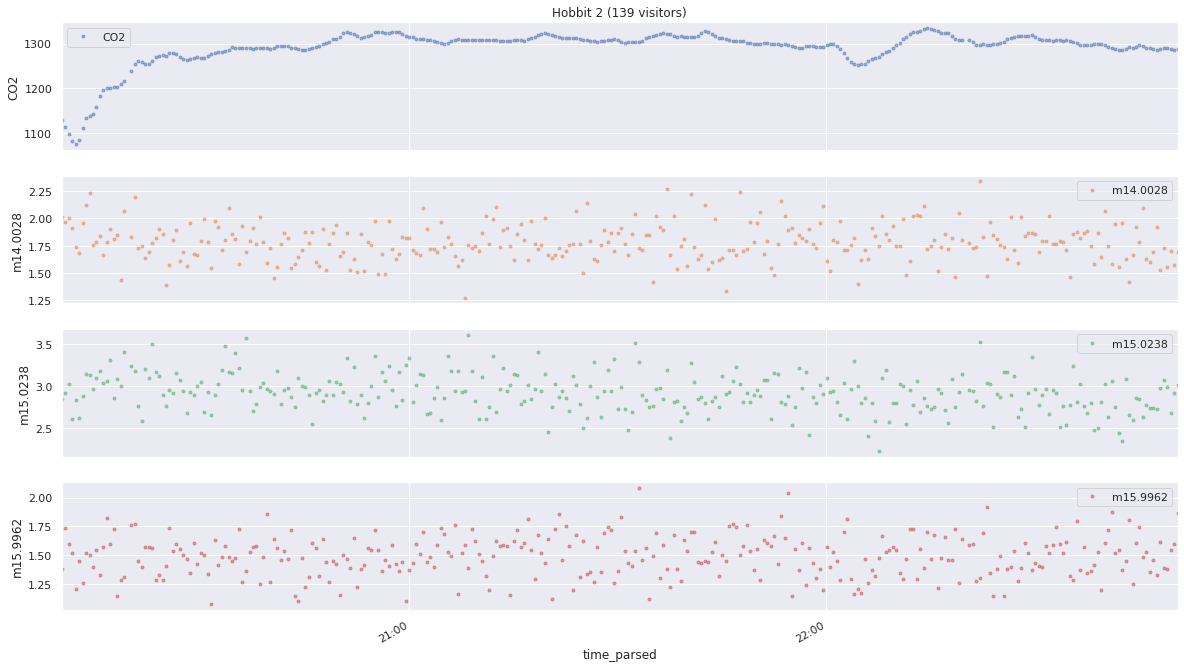

Walter Mitty 198


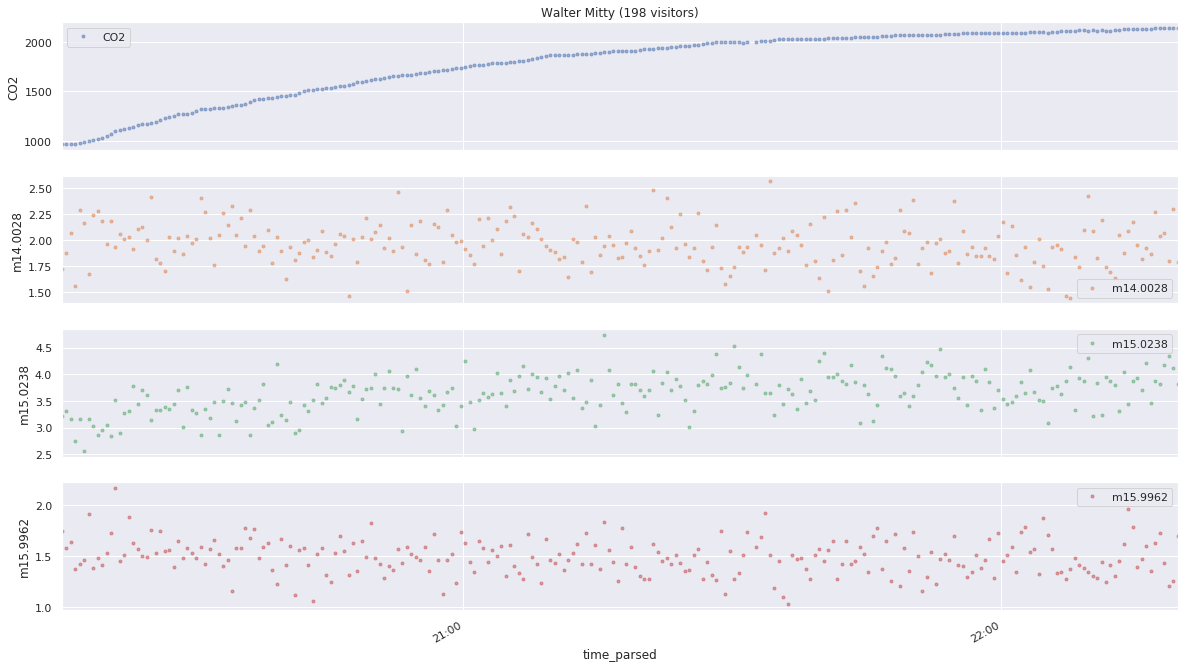

Dinosaurier 7


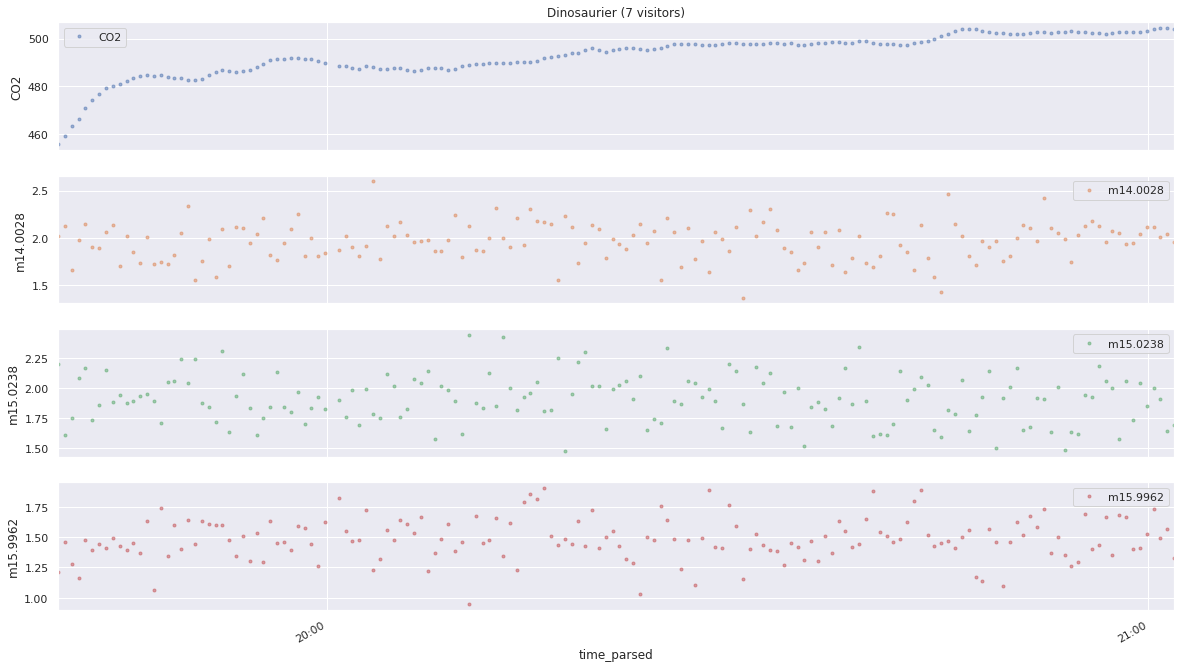

In [154]:
for index in real_test_indexes:
    movie = df_movies.loc[df_movies['sample index']==index]
    start = movie.index[0]
    end = movie.index[-1]
    print(movie.loc[start,'movie'], movie.loc[start, 'number visitors'])

    #plt.title(movie.loc[start,'movie'])
    plot_by_hour(df_movies,start, end,df_movies.columns[1:5],title=movie.loc[start,'movie'] + ' ({} visitors)'.format(movie.loc[start, 'number visitors']))
    plt.close()

In [136]:
transformed_padded = pad_sequences(transformed_movie_data,dtype='float64')
np.save('../data/pca_sequences.npy', transformed_padded)

In [34]:
padded_dataset =  pad_sequences(movie_data,dtype='float64')
np.save('../data/labels.npy',movie_labels)
np.save('../data/padded_sequences.npy', padded_dataset)

In [35]:
lab = np.load('../data/labels.npy')
mov = np.load('../data/padded_sequences.npy')